# Homework 2: Due 2017-10-18 (Wednesday)

I used the Bogacki-Shampine method to implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.

In [31]:
import numpy as np
import scipy as sp
import scipy.integrate
from matplotlib import pyplot as plt

def rk_butcher_bs3():
    """ create butcher table for Bogacki-Shampine method with embedded error estimate
    this has been adapted from @jedbrown 's FDTransient notebook.
    Outputs: 
    A : ndarray
        4-by-4 matrix, A of butcher table
    b : ndarray
        1-by-4 matrix, b of butcher table, order p
    b_twiddle : ndarray
        1-by-4 matrix, b_tilde of butcher table, order p-1
    
    -----------
    """
    A = np.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = np.array([2/9, 1/3, 4/9, 0])
    b_twiddle = np.array([7/24, 1/4, 1/3, 1/8])
                     
    return A, b, b_twiddle


def ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=True):
    """returns approximation, times, and number of function evaluations.
    this code has been adapted from @jedbrown 's FDTransient notebook
    """
    A, b, b_twiddle = rk_butcher_bs3()
    c = np.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    ti = [t]
    hist = [u0]
    fun_eval = 0
    while t < tfinal:
        
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = np.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi = Yi+ (h * A[i,j] * fY[:,j])
            fY[:,i] = f(Yi, t + h*c[i])
            fun_eval+=1
            
        if (adaptive == True):
            delta_u = h * fY.dot(b-b_twiddle)
            factor = (eps/np.linalg.norm(delta_u))**(1/3)
            factor = safety * factor
            h_star = factor * h
            if(abs(h-h_star)>=eps):
                h = h_star
                fY = np.zeros((len(u0), s))
                for i in range(s):
                    Yi = u.copy()
                    for j in range(i):
                        Yi = Yi+ (h * A[i,j] * fY[:,j])
                    fY[:,i] = f(Yi,t + h*c[i])
                    fun_eval+=1
                u =u+ h * fY.dot(b_twiddle)
                tnext = t + h
                t = tnext
                ti.append(t)
                hist.append(u.copy())
            else:
                u =u+ h * fY.dot(b_twiddle)
                t = tnext
                
                ti.append(t)
                hist.append(u.copy())
        else:
            u =u+ h * fY.dot(b_twiddle)
            t = tnext
            ti.append(t)
            hist.append(u.copy())
            
    return hist, ti, fun_eval

I tested my implementation onthe nonlinear equation $$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$ for $k=2$, $k=5$, and $k=20$. I also included a "safety factor" of 0.9 to ensure that when the timestep is adapted, it is adapted appropriately to save future function evaluations. 

## For: $k=2$, $\epsilon=10^{-6}$, $\mathbf{u}(0)=[1,1]$


In [82]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
h = 0.1
tfinal = 1
k = 2
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])

To compute absolute error in my implementation, I computed the "true" solution of the nonlinear equation using scipy's odeint. I then computed the absolute error in both $u_0$ and $u_1$ at each time step, $$error(\mathbf{u})=|f(\mathbf{u},t)-\tilde{f}(\mathbf{u},t)|,$$ and plotted this error over time.

476
2.65404369573e-05


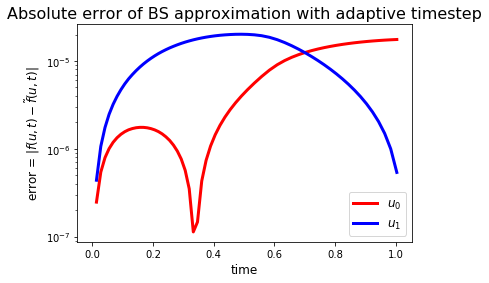

In [83]:
hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=True) #f_twiddle
print(fun_eval)
F=sp.integrate.odeint(f, u0, ti) #f

er_u0 = np.zeros(len(ti))
er_u1 = np.zeros(len(ti))
for i in range(len(ti)):
    er_u0[i] = abs(F[i][0]-hist[i][0])
    er_u1[i] = abs(F[i][1]-hist[i][1])
err = np.linalg.norm(F-hist, np.inf)
print(err)
plt.semilogy(ti, er_u0, 'r', label=r'$u_0$', linewidth = '3')
plt.semilogy(ti, er_u1, 'b', label=r'$u_1$',linewidth = '3')
plt.legend(loc='best',fontsize = '12')
plt.xlabel('time',fontsize = '12')
plt.ylabel(r'error = $|f(u,t)-\tilde{f}(u,t)|$',fontsize = '12')
plt.title(r'Absolute error of BS approximation with adaptive timestep',fontsize = '16')
plt.show()

## For: $k=5$, $\epsilon=10^{-6}$, $\mathbf{u}(0)=[1,1]$

616
2.32241562279e-05


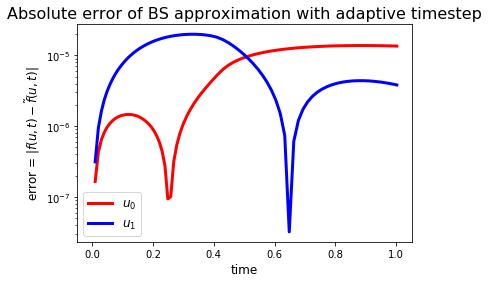

In [96]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
h = 0.1
tfinal = 1
k = 5
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])

hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=True) #f_twiddle
print(fun_eval)
F=sp.integrate.odeint(f, u0, ti) #f

er_u0 = np.zeros(len(ti))
er_u1 = np.zeros(len(ti))
for i in range(len(ti)):
    er_u0[i] = abs(F[i][0]-hist[i][0])
    er_u1[i] = abs(F[i][1]-hist[i][1])
err = np.linalg.norm(F-hist, np.inf)
print(err)
plt.semilogy(ti, er_u0, 'r', label=r'$u_0$', linewidth = '3')
plt.semilogy(ti, er_u1, 'b', label=r'$u_1$',linewidth = '3')
plt.legend(loc='best',fontsize = '12')
plt.xlabel('time',fontsize = '12')
plt.ylabel(r'error = $|f(u,t)-\tilde{f}(u,t)|$',fontsize = '12')
plt.title(r'Absolute error of BS approximation with adaptive timestep',fontsize = '16')
plt.show()

## For: $k=20$, $\epsilon=10^{-6}$, $\mathbf{u}(0)=[1,1]$

816
2.08841768161e-05


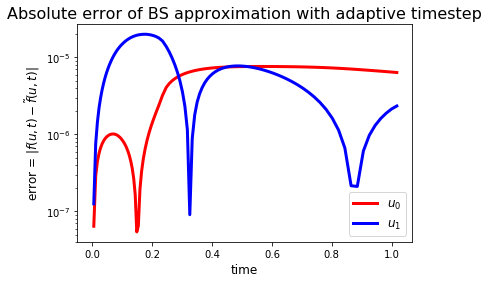

In [97]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
h = 0.1
tfinal = 1
k = 20
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])

hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=True) #f_twiddle
print(fun_eval)
F=sp.integrate.odeint(f, u0, ti) #f

er_u0 = np.zeros(len(ti))
er_u1 = np.zeros(len(ti))
for i in range(len(ti)):
    er_u0[i] = abs(F[i][0]-hist[i][0])
    er_u1[i] = abs(F[i][1]-hist[i][1])
err = np.linalg.norm(F-hist, np.inf)
print(err)
plt.semilogy(ti, er_u0, 'r', label=r'$u_0$', linewidth = '3')
plt.semilogy(ti, er_u1, 'b', label=r'$u_1$',linewidth = '3')
plt.legend(loc='best',fontsize = '12')
plt.xlabel('time',fontsize = '12')
plt.ylabel(r'error = $|f(u,t)-\tilde{f}(u,t)|$',fontsize = '12')
plt.title(r'Absolute error of BS approximation with adaptive timestep',fontsize = '16')
plt.show()

## Without adaptive timesteps, for $h=0.1$
To create a work precision diagram, I included a counter in my implemenation to keep track of the number of times $f(t,u)$ was evaluated. To compare my adaptive time-stepping implementation to that with constant timesteps, $h$, I have counted the number of times $f(t,u)$ was evaluated at decreasing timesteps, $h$. 

In [101]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
hs = np.logspace(-3, -1,20)
tfinal = 1
k = 2
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])
i=0
err=np.zeros(len(hs))
fe=np.zeros(len(hs))
for h in hs:
    hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=False) #f_twiddle
    fe[i]=fun_eval
    F=sp.integrate.odeint(f, u0, ti) #f
    err[i] = np.linalg.norm(F-hist, np.inf)
    #print(err[i], h)
    i+=1


In the below plot, the red line represents the infinity norm of the error between our approximation and the "true" solution as computed by scipy's odeint. We compare this to the number of function evaluations of the adaptive timestep method and its associated error norm, represented by the intersection of the dashed blue lines 

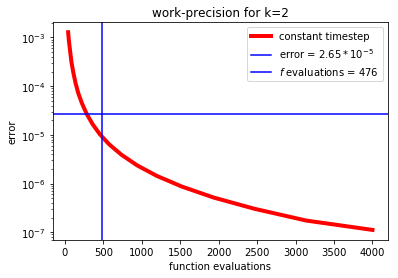

In [102]:
plt.semilogy(fe, err, 'r', linewidth='4', label='constant timestep')
plt.axhline(y=2.65*10**-5,color='b',label=r'error = $2.65*10^{-5}$')
plt.axvline(x=476,color='b',label=r'$f$ evaluations = 476')
plt.ylabel('error')
plt.xlabel('function evaluations')
plt.legend(loc='best')
plt.title(r'work-precision for k=2')
plt.show()

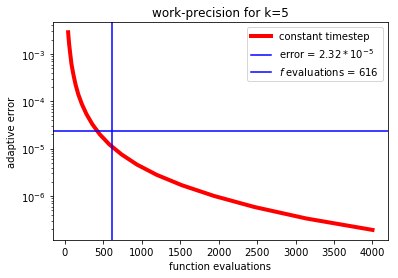

In [103]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
hs = np.logspace(-3, -1,20)
tfinal = 1
k = 5
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])
i=0
err=np.zeros(len(hs))
fe=np.zeros(len(hs))
for h in hs:
    hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=False) #f_twiddle
    fe[i]=fun_eval
    F=sp.integrate.odeint(f, u0, ti) #f
    err[i] = np.linalg.norm(F-hist, np.inf)
    #print(err[i], h)
    i+=1
plt.semilogy(fe, err, 'r', linewidth='4', label='constant timestep')
plt.axhline(y=2.32*10**-5,color='b',label=r'error = $2.32*10^{-5}$')
plt.axvline(x=616,color='b',label=r'$f$ evaluations = 616')
plt.ylabel('error')
plt.xlabel('function evaluations')
plt.legend(loc='best')
plt.title(r'work-precision for k=5')
plt.show()

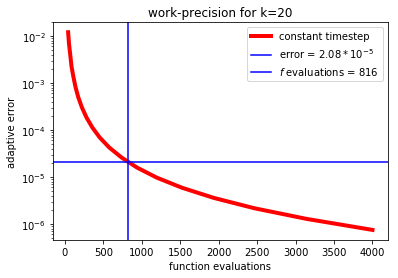

In [104]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
hs = np.logspace(-3, -1,20)
tfinal = 1
k = 20
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])
i=0
err=np.zeros(len(hs))
fe=np.zeros(len(hs))
for h in hs:
    hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=False) #f_twiddle
    fe[i]=fun_eval
    F=sp.integrate.odeint(f, u0, ti) #f
    err[i] = np.linalg.norm(F-hist, np.inf)
    #print(err[i], h)
    i+=1
plt.semilogy(fe, err, 'r', linewidth='4', label='constant timestep')
plt.axhline(y=2.08*10**-5,color='b',label=r'error = $2.08*10^{-5}$')
plt.axvline(x=816,color='b',label=r'$f$ evaluations = 816')
plt.ylabel('error')
plt.xlabel('function evaluations')
plt.legend(loc='best')
plt.title(r'work-precision for k=20')
plt.show()

We see that the constant timestepping is less expensive for values of $k$ less than 20. As $k$ increases and our system gets more stiff, however, the adaptive timestep method becomes comparatively less expensive, as we see in the below plots. 

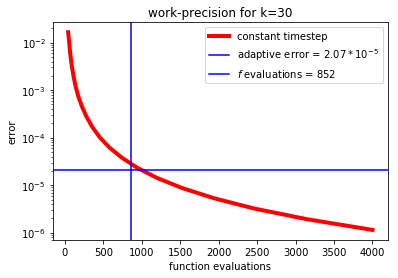

In [109]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
hs = np.logspace(-3, -1,20)
tfinal = 1
k = 30
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])
i=0
err=np.zeros(len(hs))
fe=np.zeros(len(hs))
for h in hs:
    hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=False) #f_twiddle
    fe[i]=fun_eval
    F=sp.integrate.odeint(f, u0, ti) #f
    err[i] = np.linalg.norm(F-hist, np.inf)
    #print(err[i], h)
    i+=1
plt.semilogy(fe, err, 'r', linewidth='4', label='constant timestep')
plt.axhline(y=2.07*10**-5,color='b',label=r'error = $2.07*10^{-5}$')
plt.axvline(x=852,color='b',label=r'$f$ evaluations = 852')
plt.ylabel('error')
plt.xlabel('function evaluations')
plt.legend(loc='best')
plt.title(r'work-precision for k=30')
plt.show()

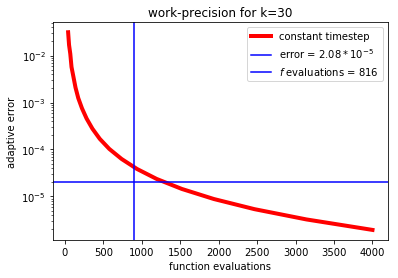

In [108]:
eps = 10** -6
safety = 0.9
u0=np.array([1.,1.])
hs = np.logspace(-3, -1,20)
tfinal = 1
k = 50
def f(u,t):
    return np.array([u[1], k * (1 - u[0]**2) * u[1] - u[0]])
i=0
err=np.zeros(len(hs))
fe=np.zeros(len(hs))
for h in hs:
    hist, ti, fun_eval = ode_rkexplicit(f, u0, tfinal, h, eps, safety, adaptive=False) #f_twiddle
    fe[i]=fun_eval
    F=sp.integrate.odeint(f, u0, ti) #f
    err[i] = np.linalg.norm(F-hist, np.inf)
    #print(err[i], h)
    i+=1
plt.semilogy(fe, err, 'r', linewidth='4', label='constant timestep')
plt.axhline(y=2.06*10**-5,color='b',label=r'error = $2.08*10^{-5}$')
plt.axvline(x=900,color='b',label=r'$f$ evaluations = 816')
plt.ylabel('adaptive error')
plt.xlabel('function evaluations')
plt.legend(loc='best')
plt.title(r'work-precision for k=50')
plt.show()

Even more numerical experiments could be done to evaluate the work-precision when the adaptive method has a different safety factor or a different epsilon tolerance. We must also consider that these diagrams represent the related information for only one test problem. 